In [ ]:
from transformers import pipeline
import  argparse
import pandas as pd
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install seaborn

In [ ]:
import numpy as np

In [ ]:
pipe = pipeline("text-classification", model="roberta-base-openai-detector")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/test-data.csv')
prediction_all = []
actual_all = []
prediction_gemini_real = []
actual_gemini_real = []
prediction_gpt_real = []
actual_gpt_real = []
for i in range(len(df)):
  candidate_text = df.candidate_text[i]
  print(candidate_text)
  print(df.label[i])
  prediction = json.dumps(pipe(candidate_text)[0])
  prediction = json.loads(prediction)
  print(prediction['label'])
  prediction_all.append(prediction['label'])
  if df.label[i] == 'real':
    actual_all.append('Real')
    actual_gemini_real.append('Real')
    actual_gpt_real.append('Real')
    prediction_gpt_real.append(prediction['label'])
    prediction_gemini_real.append(prediction['label'])
  elif df.label[i] == 'gpt3.5':
    actual_all.append('Fake')
    actual_gpt_real.append('Fake')
    prediction_gpt_real.append(prediction['label'])
  elif df.label[i] == 'gemini':
    actual_all.append('Fake')
    actual_gemini_real.append('Fake')
    prediction_gemini_real.append(prediction['label'])
print(prediction_all)
print(actual_all)
labels = np.unique(prediction_all)

Multi-agent collaboration: Break down the complex Text-to-SQL task into smaller, more manageable sub-tasks handled by specialized agents
gemini
Real
DFP stands for 'DoubleClick for Publishers.'' It is an ad management and ad serving platform developed by Google. DFP enables publishers to effectively manage and serve advertisements on their websites, mobile apps, videos, and other digital platforms. Publishers can use DFP to control various aspects of their ad operations, including ad inventory management, ad targeting, ad trafficking, reporting, and optimization.
gpt3.5
Fake
Hey there, wassup?
real
Fake
The paper 'MAC-SQL: A Multi-Agent Collaborative Framework for Text-to-SQL' proposes a new approach to translating natural language questions into SQL queries for large databases. Existing methods based on large language models (LLMs) struggle with complex questions and very large databases.
real
Real
The powerful ability to understand, follow, and generate complex language emerging from

['Fake' 'Real']


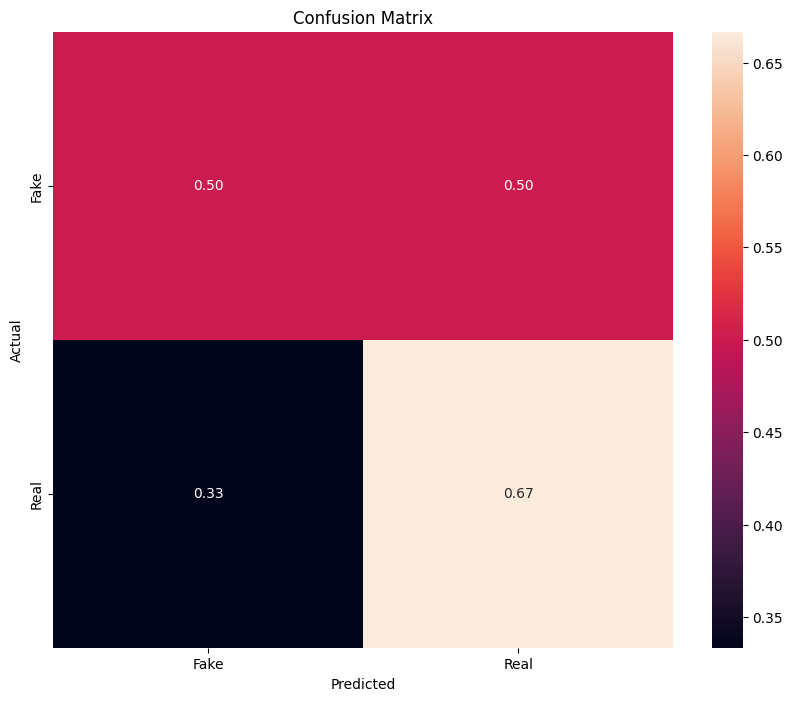

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print(labels)
conf_matrix = confusion_matrix(actual_all, prediction_all)
cm = conf_matrix
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=["Fake","Real"], yticklabels=["Fake","Real"])
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

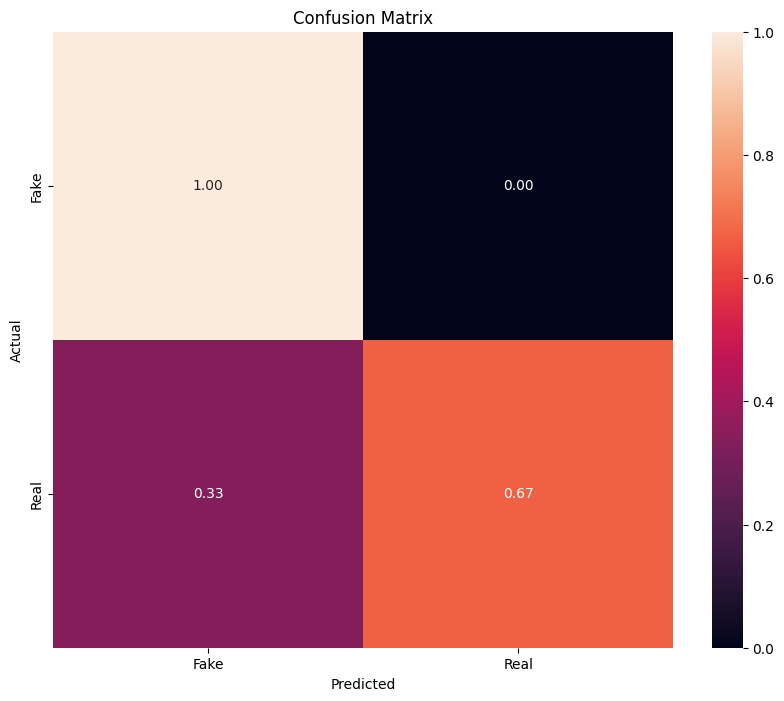

In [ ]:
conf_matrix = confusion_matrix(actual_gpt_real, prediction_gpt_real)
cm = conf_matrix
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=["Fake","Real"], yticklabels=["Fake","Real"])
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

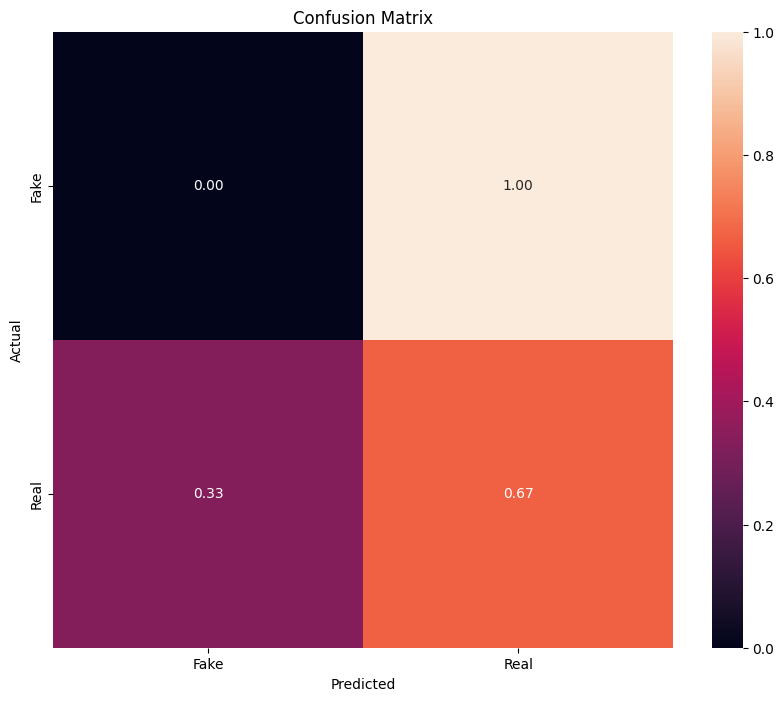

In [ ]:
conf_matrix = confusion_matrix(actual_gemini_real, prediction_gemini_real)
cm = conf_matrix
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=["Fake","Real"], yticklabels=["Fake","Real"])
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
import time
from transformers import T5Tokenizer, T5ForConditionalGeneration
class DipperParaphraser(object):
    def __init__(self, model="kalpeshk2011/dipper-paraphraser-xxl", verbose=True):
        time1 = time.time()
        self.tokenizer = T5Tokenizer.from_pretrained('google/t5-v1_1-xxl')
        self.model = T5ForConditionalGeneration.from_pretrained(model)
        if verbose:
            print(f"{model} model loaded in {time.time() - time1}")
        self.model.cuda()
        self.model.eval()

    def paraphrase(self, input_text, lex_diversity, order_diversity, prefix="", sent_interval=3, **kwargs):
        """Paraphrase a text using the DIPPER model.

        Args:
            input_text (str): The text to paraphrase. Make sure to mark the sentence to be paraphrased between <sent> and </sent> blocks, keeping space on either side.
            lex_diversity (int): The lexical diversity of the output, choose multiples of 20 from 0 to 100. 0 means no diversity, 100 means maximum diversity.
            order_diversity (int): The order diversity of the output, choose multiples of 20 from 0 to 100. 0 means no diversity, 100 means maximum diversity.
            **kwargs: Additional keyword arguments like top_p, top_k, max_length.
        """
        assert lex_diversity in [0, 20, 40, 60, 80, 100], "Lexical diversity must be one of 0, 20, 40, 60, 80, 100."
        assert order_diversity in [0, 20, 40, 60, 80, 100], "Order diversity must be one of 0, 20, 40, 60, 80, 100."

        lex_code = int(100 - lex_diversity)
        order_code = int(100 - order_diversity)

        input_text = " ".join(input_text.split())
        sentences = sent_tokenize(input_text)
        prefix = " ".join(prefix.replace("\n", " ").split())
        output_text = ""

        for sent_idx in range(0, len(sentences), sent_interval):
            curr_sent_window = " ".join(sentences[sent_idx:sent_idx + sent_interval])
            final_input_text = f"lexical = {lex_code}, order = {order_code}"
            if prefix:
                final_input_text += f" {prefix}"
            final_input_text += f" <sent> {curr_sent_window} </sent>"

            final_input = self.tokenizer([final_input_text], return_tensors="pt")
            final_input = {k: v.cuda() for k, v in final_input.items()}

            with torch.inference_mode():
                outputs = self.model.generate(**final_input, **kwargs)
            outputs = self.tokenizer.batch_decode(outputs, skip_special_tokens=True)
            prefix += " " + outputs[0]
            output_text += " " + outputs[0]

        return output_text

if __name__ == "__main__":
    dp = DipperParaphraser()

    prompt = "In a shocking finding, scientist discovered a herd of unicorns living in a remote valley."
    input_text = "They have never been known to mingle with humans. Today, it is believed these unicorns live in an unspoilt environment which is surrounded by mountains. Its edge is protected by a thick wattle of wattle trees, giving it a majestic appearance. Along with their so-called miracle of multicolored coat, their golden coloured feather makes them look like mirages. Some of them are rumored to be capable of speaking a large amount of different languages. They feed on elk and goats as they were selected from those animals that possess a fierceness to them, and can \"eat\" them with their long horns."

    print(f"Input = {prompt} <sent> {input_text} </sent>\n")
    output_l60_sample = dp.paraphrase(input_text, lex_diversity=60, order_diversity=0, prefix=prompt, do_sample=True, top_p=0.75, top_k=None, max_length=512)
    print(f"Output (Lexical diversity = 60, Sample p = 0.75) = {output_l60_sample}\n")


tokenizer_config.json:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/593 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/764 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/50.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00005.bin:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

device = "cuda"

tokenizer = AutoTokenizer.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base")

model = AutoModelForSeq2SeqLM.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base").to(device)

def paraphrase(
    question,
    num_beams=5,
    num_beam_groups=5,
    num_return_sequences=5,
    repetition_penalty=10.0,
    diversity_penalty=3.0,
    no_repeat_ngram_size=2,
    temperature=0.7,
    max_length=128
):
    input_ids = tokenizer(
        f'paraphrase: {question}',
        return_tensors="pt", padding="longest",
        max_length=max_length,
        truncation=True,
    ).input_ids.to(device)

    outputs = model.generate(
        input_ids, temperature=temperature, repetition_penalty=repetition_penalty,
        num_return_sequences=num_return_sequences, no_repeat_ngram_size=no_repeat_ngram_size,
        num_beams=num_beams, num_beam_groups=num_beam_groups,
        max_length=max_length, diversity_penalty=diversity_penalty
    )

    res = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return res


In [ ]:
text = 'What are the best places to see in New York?'
paraphrase(text)

['What are some must-see places in New York?',
 'Can you suggest some must-see spots in New York?',
 'Where should one go to experience the best NYC has to offer?',
 'Which places should I visit in New York?',
 'What are the top destinations to explore in New York?']

In [ ]:
!pip install wget

In [ ]:
import wget
import os
filename = []
output_directory = "/content/drive/MyDrive"
urls = ['https://raw.githubusercontent.com/mbzuai-nlp/M4/main/data/arxiv_bloomz.jsonl',
        'https://raw.githubusercontent.com/mbzuai-nlp/M4/main/data/arxiv_chatGPT.jsonl',
        'https://raw.githubusercontent.com/mbzuai-nlp/M4/main/data/arxiv_cohere.jsonl',
        'https://raw.githubusercontent.com/mbzuai-nlp/M4/main/data/arxiv_davinci.jsonl',
        'https://raw.githubusercontent.com/mbzuai-nlp/M4/main/data/arxiv_flant5.jsonl']

for url in urls:
    output_filename = output_directory + '/' + os.path.basename(url) # get the full path of the file
    if os.path.exists(output_filename):
        os.remove(output_filename) # if exist, remove it directly
    filename.append(wget.download(url, out=output_filename))
print(filename)



['/content/drive/MyDrive/arxiv_bloomz.jsonl', '/content/drive/MyDrive/arxiv_chatGPT.jsonl', '/content/drive/MyDrive/arxiv_cohere.jsonl', '/content/drive/MyDrive/arxiv_davinci.jsonl', '/content/drive/MyDrive/arxiv_flant5.jsonl']


In [ ]:
import json
# List to store the data with paraphrased abstracts
new_data = []

for i in range(0,5):
  print(filename[i])

  with open(filename[i], mode='r') as input_file:
    data = input_file.readlines()  # Read all lines
    lines_number = len(data)  # Get the number of lines in the file
    print(lines_number)

/content/drive/MyDrive/arxiv_bloomz.jsonl
3001
/content/drive/MyDrive/arxiv_chatGPT.jsonl
3000
/content/drive/MyDrive/arxiv_cohere.jsonl
3000
/content/drive/MyDrive/arxiv_davinci.jsonl
3000
/content/drive/MyDrive/arxiv_flant5.jsonl
3000


In [ ]:
import json
# List to store the data with paraphrased abstracts
new_data = []
lines_number = 3000
for i in range(0,1):
  print(filename[i])

  with open(filename[i], mode='r') as input_file:

    data = [next(input_file) for _ in range(lines_number)]
    #print(data)
    print(len(data))

  for item in data:
    item = json.loads(item)
    #print("The abstract is:",  item["abstract"])
    # Paraphrase the abstract
    paraphrased_abstract = paraphrase(item["machine_abstract"])
    #print("Paraprased text",paraphrased_abstract)
    # Add the paraphrased abstract to the item
    item["paraphrased_abstract"] = paraphrased_abstract
    # Add the modified item to the new data list
    new_data.append(item)
    #print("the new data is",  new_data)

  # Define the output filename /content/drive/MyDrive/arxiv_bloomz.jsonl'
  drive_path = "/content/drive/MyDrive"
  newfilename = f"paraphrased_{filename[i].split('/')[-1]}"  # Extract filename from path
  output_filename = f"{drive_path}/{newfilename}"
  print(output_filename)


  # Write the new data with paraphrased abstracts to a JSON file
  with open(output_filename, mode='w') as output_file:
      # Write each item to the file
      for item in new_data:
          json.dump(i, output_file)
          output_file.write('\n')

  print("Paraphrased data has been written to:", output_filename)



/content/drive/MyDrive/arxiv_bloomz.jsonl
3000
